In [2]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import ast

/home/max/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
datasets = ["Hall","Kitchenham","Radjenovic","Wahono"]

dfs = []

bad_abstract = '<div style="font-variant: small-caps; font-size: .9em;">First Page of the Article</div><img class="img-abs-container" style="width: 95%; border: 1px solid #808080;" src="/xploreAssets/images/absImages/01618458.png" border="0">'

cols = ["Document Title", "Abstract", "label"]
for d in datasets:
    df = pd.read_csv(f'../data/fastread/{d}.csv', encoding="ISO-8859-1")[cols]
    df.loc[df['label']=="no", "relevant"] = 0
    df.loc[df['label']=="yes", "relevant"] = 1
    df.loc[df['Abstract']==bad_abstract, "Abstract"] = np.NaN
    df["review"] = d
    dfs.append(df)
    
df = pd.concat(dfs)
df.head()

,Document Title,Abstract,label,relevant,review
0,Sinogram-based motion correction of PET images...,A head motion during brain imaging has been re...,no,0.0,Hall
1,A fault tolerant control architecture for auto...,A hierarchical controller for dealing with fau...,no,0.0,Hall
2,Fault tolerant memory design for HW/SW co-reli...,A highly dependable embedded fault-tolerant me...,no,0.0,Hall
3,Efficient color correction approach for phase ...,A highly efficient color correction approach b...,no,0.0,Hall
4,High-performance line conditioner with output ...,A high-performance line conditioner with excel...,no,0.0,Hall


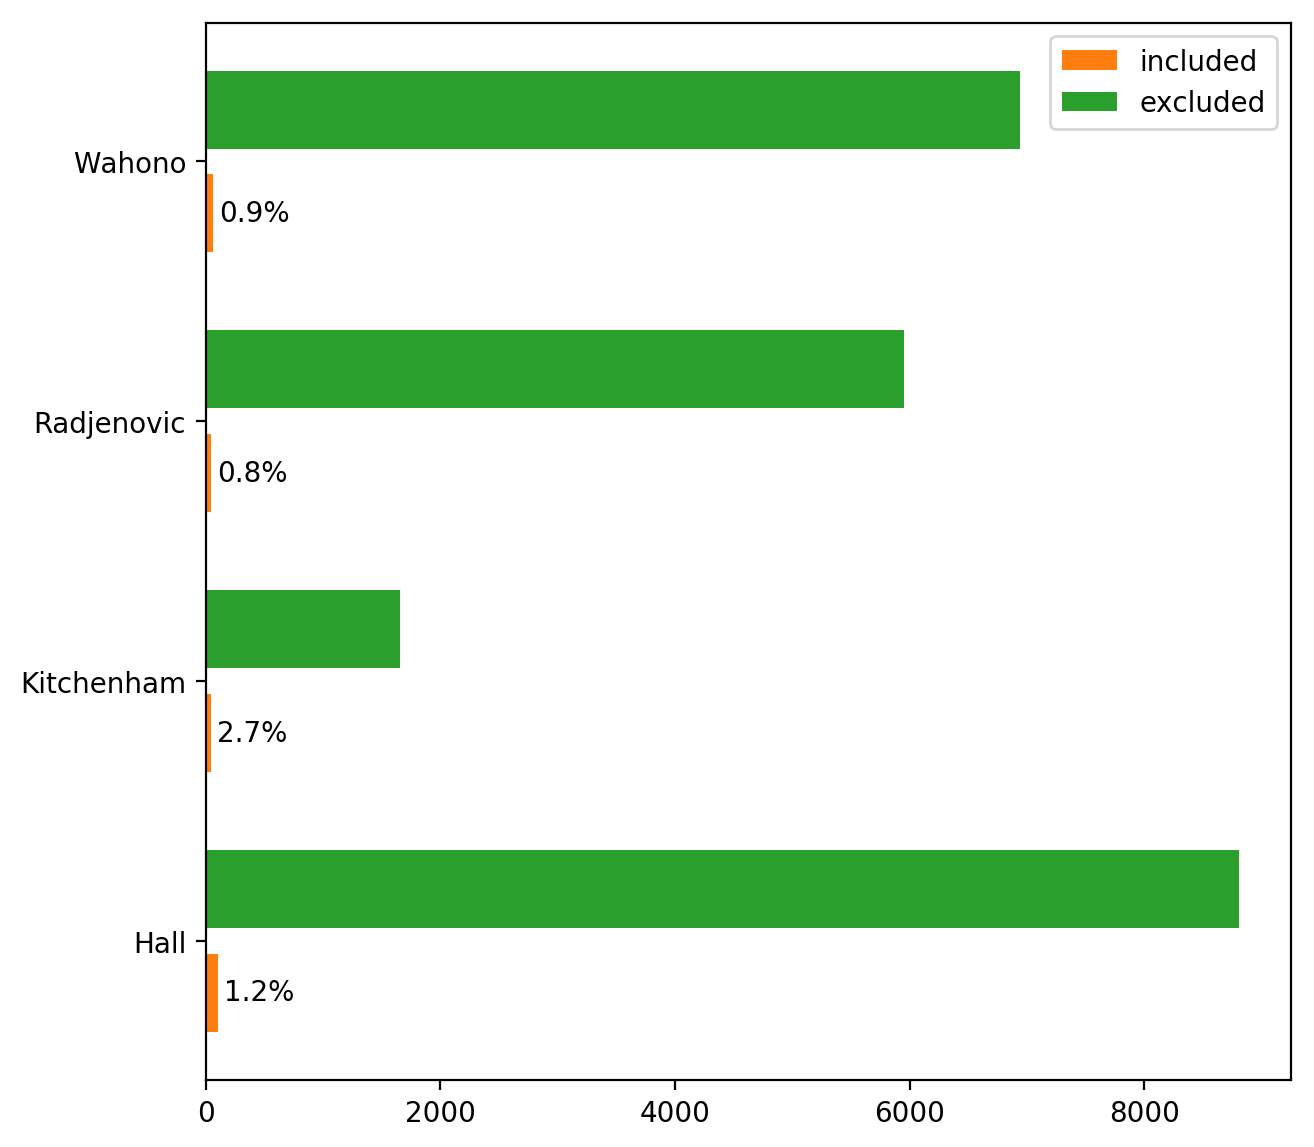

In [4]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(df.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/excluded:.1%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [7]:
importlib.reload(rr)

results = []
iterations = 1

df['x'] = df['Abstract'].str.cat(df['Document Title'], sep=" ")

recalculate = True
if recalculate:
    for name, group in df.groupby('review'):
        group = group.dropna().reset_index(drop=True)

        if name != "Radjenovic":
            continue
        models = [
            
            #SVC(kernel='linear',class_weight='balanced',probability=True)
            #MultinomialNB(alpha=0.1)    
            MLPClassifier(
                solver='lbfgs', alpha=0.1,
                hidden_layer_sizes=(10), random_state=1
            )
        ]

        ss = rr.ScreenScenario(
            group, models, 500, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, True))

    results_df = pd.DataFrame.from_dict(results)
else:
    results_df = pd.read_csv('../results/results_pb_copd.csv') 
    for p in ["estimated_recall_path", "recall_track", "work_track","random_work_track","random_recall_track"]:
        results_df[p] = results_df[p].apply(ast.literal_eval)
    
results_df.head()

Dataset: Kitchenham, iteration 0.  1700 out of 1700 documents seen (100%) - recall: 100.00%, probable recall: 0.00%


,dataset,models,N,r_docs,p,bir,bir_upperbound,seen_docs,r_seen,r_predicted,...,estimated_recall_min,hypothetical_95,hyper_prob_pmf,hyper_prob,hyper_interval,recall_rs,recall_hyper,recall_ih_100,recall_ih_200,recall_nrs
0,Kitchenham,"[MLPClassifier(activation='relu', alpha=0.1, b...",1700,45,0.026471,0.024,0.041941,1700,45,41,...,1.0,6.0,0.0,0.0,"(6.0, 6.0)",1.0,1.0,0.977778,0.977778,0.977778


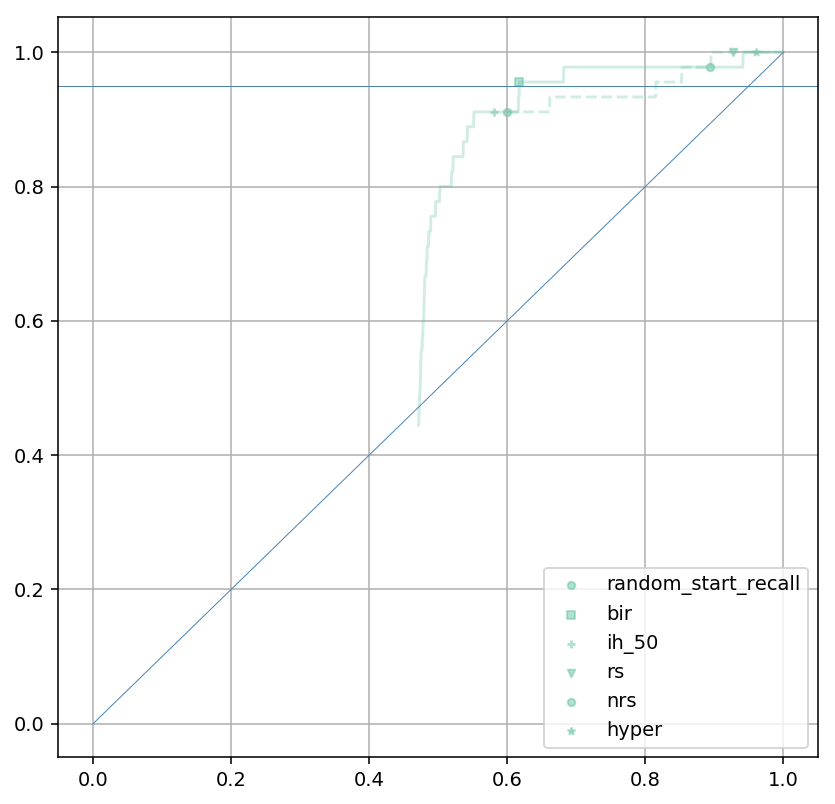

In [6]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.3
size = 15

pdf = results_df[results_df['N'] > 1000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    #ax.plot(p['random_work_track'], p['estimated_recall_path'])
    
s_crit = ["bir","ih_50","rs","nrs","hyper"]

import itertools
marker = itertools.cycle((',', '+', 'v', 'o', '*')) 

ax.scatter(pdf['random_start_work'],pdf['random_start_recall'],c=colors[0],s=size,alpha=a+0.2)

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss95_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s,
        s = size,
        alpha=a+0.2
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()

In [29]:
self = ss
df = self.df
for i, r in df[(df['seen']==0) & (df['relevant']==1)].head().iterrows():
    print(r['Abstract'])
    print(r['Document Title'])
    print()

In [30]:
for i, r in df[(df['seen']==1) & (df['relevant']==1)].head().iterrows():
    print(r['Abstract'])
    print()

Describes the results of a study where the impact of object-oriented (OO) design on software quality characteristics is experimentally evaluated. A suite of Metrics for OO Design (MOOD) was adopted to measure the use of OO design mechanisms. Data collected on the development of eight small-sized information management systems based on identical requirements were used to assess the referred impact. Data obtained in this experiment show how OO design mechanisms such as inheritance, polymorphism, information hiding and coupling, can influence quality characteristics like reliability or maintainability. Some predictive models based on OO design metrics are also presented

This paper presents the results of a study in which we empirically investigated the suite of object-oriented (OO) design metrics introduced in (Chidamber and Kemerer, 1994). More specifically, our goal is to assess these metrics as predictors of fault-prone classes and, therefore, determine whether they can be used as ear

In [19]:
df.head()

,Document Title,Abstract,label,relevant,review,x,seen,outlying
0,Diagnostic Maintenance: A Technique Using a Co...,A possible technique and the attending softwar...,no,0.0,Radjenovic,A possible technique and the attending softwar...,0,1
1,A Very High Speed Electro-Optical-Mechanical P...,Adanced-performance automated phototypesetting...,no,0.0,Radjenovic,Adanced-performance automated phototypesetting...,0,1
2,Recognition of Handprinted Numerals by Two-Sta...,An optical character recognition system for ha...,no,0.0,Radjenovic,An optical character recognition system for ha...,0,1
3,Computer Diagnosis Using the Blocking Gate App...,In previous papers [3]â[5] the authors consi...,no,0.0,Radjenovic,In previous papers [3]â[5] the authors consi...,0,1
4,Simulation modeling for air quality control,Simulation modeling will have a major role in ...,no,0.0,Radjenovic,Simulation modeling will have a major role in ...,0,1
